# Getting Started with PySpark

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf

In [2]:
# set some spark conf
spark_conf = SparkConf() \
    .setAppName("anomaly_modelling") \
    .set("spark.driver.memory", "12g") \
    .setMaster('local[*]')

In [3]:
#sc.stop()

In [4]:
sc = SparkContext(conf = spark_conf)

In [5]:
# get our sparksession
from pyspark.sql import SparkSession
spark = SparkSession(sc).builder.getOrCreate()#.config("spark.driver.cores", "4")

In [6]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'anomaly_modelling'),
 ('spark.driver.memory', '12g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '34943'),
 ('spark.driver.host', '346169229b3a'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1604803385280')]

## Load My Test file

In [7]:
txt = spark.read.parquet('data/*')
print(txt.count())

13758561


In [8]:
txt.select("key", "totaltime", "objectsize").describe().show()

+-------+------------+------------------+--------------------+
|summary|         key|         totaltime|          objectsize|
+-------+------------+------------------+--------------------+
|  count|    13758561|          13638028|            12791918|
|   mean|        null|27.549267460075605|  1516564.8832174346|
| stddev|        null| 65.15363121886377|1.4335017325813163E7|
|    min|           -|                 1|                   0|
|    max|prefix/dummy|             29596|          2118650593|
+-------+------------+------------------+--------------------+



## Do Some Processing

Some things that we will have to get comfortable with include:
- Managing driver RAM
- How to work with stuff that doesn't all fit in driver RAM / executor RAM
- using Python libs in this situation

In [113]:
import seaborn as sns
%matplotlib inline
from scipy.stats import beta, norm
import numpy as np 

In [114]:
totaltime_object = txt.select("totaltime").take(500000)

totaltime object is a DataFrame object which numpy and scipy cannot deal with so we need to convert it first. Taking the full object is also too big for us to fit into the driver RAM

In [115]:
totaltime_np = np.array(totaltime_object).flatten()
#totaltime_np = totaltime_np[~np.isnan(totaltime_np)]

Note that we needed to convert to float in order fo the fitting to be done properly

In [117]:
a1, b1, loc1, scale1 = beta.fit(np.array(totaltime_np[0:10], dtype=float))

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Now we can sample values.
Lets sample then plot

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

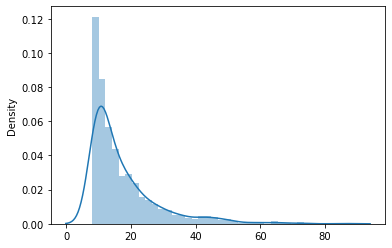

In [118]:
r = beta.rvs(a1, b1, loc1, scale1, size=1000)
sns.distplot(r)

In [119]:
# trying normfit
norm.fit(np.array(totaltime_np[0:10], dtype=float))

(24.6, 25.64449258612851)

# Extract the AWS Prefix

we need to extract and analyse data by the AWS Prefix

In [49]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [154]:
def get_object(s):
    splitted = s.split("/")
    return splitted[-1]

getobject_udf = udf(get_object, StringType())

def get_prefix(s):
    splitted = s.split("/")
    prefix = "/".join(splitted[0:-1])
    return prefix

getprefix_udf = udf(get_prefix, StringType())

In [81]:
txt.select("key", getobject_udf("key").alias("object"), getprefix_udf("key").alias("prefix")).take(3)

[Row(key='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2/part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000', object='part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000', prefix='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2'),
 Row(key='dmp/edh_fs_config/internal/compactionrunlog_dim/part-00000-33c61448-c1cf-4618-aebf-26e88844d6e2-c000', object='part-00000-33c61448-c1cf-4618-aebf-26e88844d6e2-c000', prefix='dmp/edh_fs_config/internal/compactionrunlog_dim'),
 Row(key='dmp/rawcleansed/edh_mcoe_hana/iflotx/partition%253D1/part-00010-8640b6e7-2068-442e-84c3-5ae6b8f8adf8.c000', object='part-00010-8640b6e7-2068-442e-84c3-5ae6b8f8adf8.c000', prefix='dmp/rawcleansed/edh_mcoe_hana/iflotx/partition%253D1')]

In [82]:
txt.columns

['bucketowner',
 'bucket',
 'requestdatetime',
 'remoteip',
 'requester',
 'requestid',
 'operation',
 'key',
 'request',
 'httpstatus',
 'errorcode',
 'bytessent',
 'objectsize',
 'totaltime',
 'turnaroundtime',
 'referrer',
 'useragent',
 'versionid',
 'hostid',
 'sigv',
 'ciphersuite',
 'authtype',
 'endpoint',
 'tlsversion',
 'requesturi_operation',
 'requesturi_key',
 'requesturi_httpprotoversion',
 'requesttimestamp']

In [168]:
txt.filter( col("key").startswith("dmp") ).take(10)

[Row(bucketowner='7409ed49bee6816819d2bd188ea9a867fa08ec38745cb08957f87f512ead10b6', bucket='alpha2-prod', requestdatetime='13/Jun/2020:04:02:44 +0000', remoteip='10.121.230.112', requester='arn:aws:iam::755270036439:user/CTSalpha2prodbucketuser', requestid='15F944538A1C9654', operation='REST.HEAD.OBJECT', key='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2/part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000', request='"HEAD /dmp/rawcleansed/edh_mcoe_hana/afko/partition%3D2/part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000 HTTP/1.1"', httpstatus='200', errorcode='-', bytessent=None, objectsize=5957806, totaltime=11, turnaroundtime=None, referrer='"-"', useragent='"Hadoop 2.6.0-cdh5.14.4, aws-sdk-java/1.11.134 Linux/3.10.0-862.51.1.el7.x86_64 Java_HotSpot(TM)_64-Bit_Server_VM/25.162-b12/1.8.0_162"', versionid='-', hostid='nBSuS+gs/4iNasb4hxJU9YdWa3HOX+KLVF6hF+GIDz1PhpOrwMW7oauTtHIAa4/NI2btSUc/YU4=', sigv='SigV4', ciphersuite='ECDHE-RSA-AES128-SHA', authtype='AuthHeader', endpoin

In [169]:
txt2 = txt \
  .filter( col("key").startswith("dmp") ) \
  .select("requesttimestamp", "operation", "turnaroundtime", "totaltime", \
                  "objectsize", "bytessent", getobject_udf("key").alias("object"), \
                  getprefix_udf("key").alias("prefix"))

# Grouping by Time Windows

we need to use table windowing functions in order to be able to calculate time based metrics

In [170]:
# 5 tumbling minute intervals
txt2 \
  .groupBy(window("requesttimestamp", "5 minute")) \
  .count().take(3)

[Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 35), end=datetime.datetime(2020, 6, 13, 4, 40)), count=785786),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 50), end=datetime.datetime(2020, 6, 13, 4, 55)), count=1429407),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 40), end=datetime.datetime(2020, 6, 13, 4, 45)), count=993303)]

In [171]:
# advanced windows - doesn't seem like we need for now
from pyspark.sql import Window
# this is a window spec and seems to only support explicitly specifying how many rows before 
# and after each you you want
advanced_window = Window.partitionBy("prefix").orderBy("requesttimestamp")

# tumbling windows
txt2 \
  .repartition("prefix") \
  .groupBy("prefix", window("requesttimestamp", windowDuration="5 minute", slideDuration="1 minute")) \
  .count().take(3)

[Row(prefix='dmp/rawcleansed/rc_aurizon_bma/internal/wheelbearingtemp_bogie_av/structured/wheelbearingtemp_bogie_av.parquet/.hive-staging_hive_2020-06-12_23-29-23_137_5376946569663904819-1/-ext-10000/_temporary/0/_temporary/attempt_20200612232933_0105_m_000004_0/part_key%253D2020164', window=Row(start=datetime.datetime(2020, 6, 13, 4, 26), end=datetime.datetime(2020, 6, 13, 4, 31)), count=6),
 Row(prefix='dmp/rawcleansed/rc_aurizon_bma/internal/wheelbearingtemp_train_av/structured/wheelbearingtemp_train_av.parquet/part_key%253D2020140', window=Row(start=datetime.datetime(2020, 6, 13, 4, 27), end=datetime.datetime(2020, 6, 13, 4, 32)), count=270),
 Row(prefix='dmp/rawcleansed/rc_blastlogic_crm/internal/hole_av/structured', window=Row(start=datetime.datetime(2020, 6, 13, 4, 59), end=datetime.datetime(2020, 6, 13, 5, 4)), count=10)]

# Applying udafs to windows

we will need to apply User Defined Analytical Functions to the sliding / tumbling windows that we will construct in order to analyse the data

In [128]:
from scipy.stats import norm
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
from pyspark.sql.functions import col, collect_list, concat_ws, udf

In [195]:
norm_dist_schema = StructType([
    StructField("mean", FloatType(), True),
    StructField("std", FloatType(), True)
])

import numpy as np
def fit_norm_dist(s):
    # flatten the numpy 
    number_np = np.array(s).flatten()
    # run the fit and get the fit params
    #try:
    mean,std = norm.fit(np.array(number_np, dtype=float))
    #except RuntimeError:
    #    mean, std = 0,0
        
    return (float(mean), float(std))

normfit_udf = udf(fit_norm_dist, norm_dist_schema)

In [196]:
# test the base function
ans = fit_norm_dist(txt2.select("totaltime").filter(txt2.totaltime.isNotNull()).take(10000))
ans

(39.378, 78.70099564808567)

In [197]:
txt2 \
  .select("prefix", "totaltime", normfit_udf("totaltime").alias("normfit")) \
  .take(10)

[Row(prefix='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2', totaltime=11, normfit=Row(mean=11.0, std=0.0)),
 Row(prefix='dmp/edh_fs_config/internal/compactionrunlog_dim', totaltime=8, normfit=Row(mean=8.0, std=0.0)),
 Row(prefix='dmp/rawcleansed/edh_mcoe_hana/iflotx/partition%253D1', totaltime=18, normfit=Row(mean=18.0, std=0.0)),
 Row(prefix='dmp/edh_fs_config/internal/compactionrunlog_dim', totaltime=10, normfit=Row(mean=10.0, std=0.0)),
 Row(prefix='dmp/rawcleansed/edh_mcoe_hana/makt/partition%253D2', totaltime=50, normfit=Row(mean=50.0, std=0.0)),
 Row(prefix='dmp/edh_fs_config/internal/compactionrunlog_dim', totaltime=10, normfit=Row(mean=10.0, std=0.0)),
 Row(prefix='dmp/rawcleansed/edh_mcoe_hana/aufk/partition%253D1', totaltime=93, normfit=Row(mean=93.0, std=0.0)),
 Row(prefix='dmp/edh_fs_config/internal/compactionrunlog_dim', totaltime=17, normfit=Row(mean=17.0, std=0.0)),
 Row(prefix='dmp/rawcleansed/edh_mcoe_hana/jest/partition%253D2', totaltime=9, normfit=Row(mean=9.0,

In [198]:
# if we don't run take it works so it means that some prefixes and window combos are weird
txt2 \
  .filter(txt2.totaltime.isNotNull()) \
  .groupBy(window("requesttimestamp", windowDuration="10 minute", slideDuration="5 minute")) \
  .agg(collect_list("totaltime").alias("tt")) \
  .withColumn("tt", normfit_udf("tt").alias("normfit")) \
  .take(10)

[Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 35), end=datetime.datetime(2020, 6, 13, 4, 45)), tt=Row(mean=24.226726531982422, std=39.19658660888672)),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 55), end=datetime.datetime(2020, 6, 13, 5, 5)), tt=Row(mean=23.87355613708496, std=42.65131759643555)),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 20), end=datetime.datetime(2020, 6, 13, 4, 30)), tt=Row(mean=24.380699157714844, std=57.64756393432617)),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 30), end=datetime.datetime(2020, 6, 13, 4, 40)), tt=Row(mean=24.036659240722656, std=39.62351608276367)),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 5), end=datetime.datetime(2020, 6, 13, 4, 15)), tt=Row(mean=25.99616241455078, std=48.79657745361328)),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 50), end=datetime.datetime(2020, 6, 13, 5, 0)), tt=Row(mean=24.014495849609375, std=43.13007354736328)),
 Row(window=Row(start=datetime.da

## Next Actions
- So given that we need to work with datasets that we cannot fit to RAM, how can we best run this job to get a "definitive" sample. - Probably don't need this Actually